Experiment description
 - Continual Learning using MLP model
 - CL strategy: Deep Generative Replay (DGR)
 - Dataset: 50% of IDS 2018 (5 out of 10 csv files)
 - Task organization: each csv file is assigned to a task, for a total of 5 tasks 
 - Data preprocessing: .h5 file -> pandas DataFrame -> Encode labels -> pytorch Dataset, DataLoader
 
Experiment Result: 
 - reasoning for the result: 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import os
import sys
dest_path = 'C:/path/to/IDS2018/data'
sys.path.append(dest_path)
import utils
from tabgan.sampler import GANGenerator


In [28]:
# Define relevant variables for the ML task
num_batch = 32
num_class = 10
num_epoch = 20

encoder = LabelEncoder()

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load full y data to encode label
y_all = pd.HDFStore(dest_path + 'ids2018_all_y.h5','r')
num_task = len(y_all.keys())

### Data Generation

In [29]:
# Load full y data to encode label
y_all = pd.HDFStore(dest_path + 'ids2018_all_y.h5','r')

df_y_all0302 = y_all.get('/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0216 = y_all.get('/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0214 = y_all.get('/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0221 = y_all.get('/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0228 = y_all.get('/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all = pd.concat([df_y_all0302, df_y_all0216, df_y_all0214, df_y_all0221, df_y_all0228], ignore_index=True)

In [30]:
encoder.fit(df_y_all)
encoder.classes_

array(['Benign', 'Bot', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP',
       'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'FTP-BruteForce',
       'Infilteration', 'SSH-Bruteforce'], dtype=object)

Fitting CTGAN transformers for each column:   0%|          | 0/78 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

<AxesSubplot:>

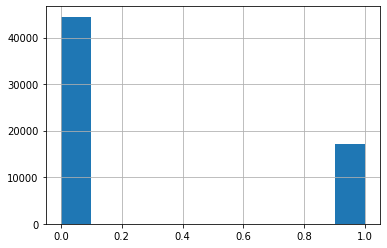

In [31]:
# Gather task 1 data
df_X11_train, df_y11_train, df_X11_val = utils.buildCombinedDataset(dest_path, 1, encoder)
df_X11_gen, df_y11_gen = GANGenerator().generate_data_pipe(df_X11_train, df_y11_train, df_X11_val,)
df_y11_gen.hist()

Fitting CTGAN transformers for each column:   0%|          | 0/78 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

<AxesSubplot:>

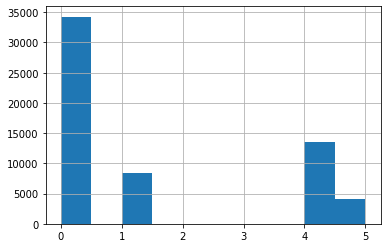

In [32]:
# Gather task 2 data
df_X12_train, df_y12_train, df_X12_val = utils.buildCombinedDataset(dest_path, 2, encoder, df_X11_gen, df_y11_gen)
df_X12_gen, df_y12_gen = GANGenerator().generate_data_pipe(df_X12_train, df_y12_train, df_X12_val,)
df_y12_gen.hist()

Fitting CTGAN transformers for each column:   0%|          | 0/78 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

<AxesSubplot:>

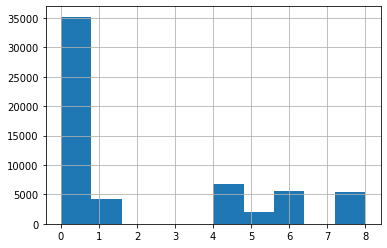

In [33]:
# Gather task 3 data
df_X13_train, df_y13_train, df_X13_val = utils.buildCombinedDataset(dest_path, 3, encoder, df_X12_gen, df_y12_gen)
df_X13_gen, df_y13_gen = GANGenerator().generate_data_pipe(df_X13_train, df_y13_train, df_X13_val,)
df_y13_gen.hist()

Fitting CTGAN transformers for each column:   0%|          | 0/78 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

<AxesSubplot:>

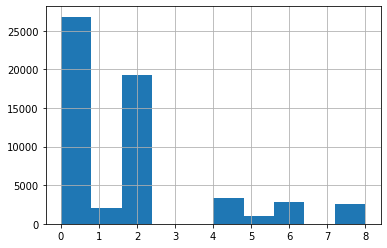

In [34]:
# Gather task 4 data
df_X14_train, df_y14_train, df_X14_val = utils.buildCombinedDataset(dest_path, 4, encoder, df_X13_gen, df_y13_gen)
df_X14_gen, df_y14_gen = GANGenerator().generate_data_pipe(df_X14_train, df_y14_train, df_X14_val,)
df_y14_gen.hist()

In [35]:
# Gather task 5 data
df_X15_train, df_y15_train, df_X15_val = utils.buildCombinedDataset(dest_path, 5, encoder, df_X14_gen, df_y14_gen)

In [71]:
# Create Datasets from DataFrames
# Task-specific train
DSs_train = []
DSs_train.append(utils.ids2018Dataset(df_X11_train, df_y11_train.squeeze().values))
DSs_train.append(utils.ids2018Dataset(df_X12_train, df_y12_train.squeeze().values))
DSs_train.append(utils.ids2018Dataset(df_X13_train, df_y13_train.squeeze().values))
DSs_train.append(utils.ids2018Dataset(df_X14_train, df_y14_train.squeeze().values))
DSs_train.append(utils.ids2018Dataset(df_X15_train, df_y15_train.squeeze().values))
# Task-specific validation
DSs_val = utils.buildDataset('val', dest_path, num_task, encoder)
# Cumulative validation
DS_cumulative_val = utils.buildDataset('val', dest_path, 1, encoder)

# Create DataLoaders from Datasets
# Task-specific train
DLs_train = []
for i in range(5):
    DLs_train.append(DataLoader(DSs_train[i], batch_size=num_batch, shuffle=True))
# Task-specific validation
DLs_val = []
for i in range(5):
    DLs_val.append(DataLoader(DSs_val[i], batch_size=num_batch, shuffle=True))
# Cumulative validation
DL_cumulative_val = DataLoader(DS_cumulative_val, batch_size=num_batch, shuffle=True)

### Model Training & Evaluation

In [72]:
# model = utils.CNN(num_class).to(device)
model = utils.MLP(input_size=77, output_size=len(encoder.classes_), hidden_dropout=True, input_dropout=True).to(device)
model.double()
#Use CrossEntropyLoss
model_criterion = nn.CrossEntropyLoss()
#Use SGD, learning rate=0.001
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [73]:
train_ac_list = []

t1_test_ac_list = []
t2_test_ac_list = []
t3_test_ac_list = []
t4_test_ac_list = []
t5_test_ac_list = []
task_ac_list = np.zeros((5,6)).tolist()

test_ac_list = []

Period 1 - pretrained: [None] training [t1_train], testing [t1_test]

In [75]:
print("Period 1 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, DLs_train[0], train_ac_list, epoch, task_idx=1)

    t1_test_ac_list = utils.testing(model, DLs_val[0], t1_test_ac_list, epoch, task_idx=1)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, DL_cumulative_val, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][0] = t1_test_ac_list[-1]  # task-specific test accuracy


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Period 1 training


 20%|████████████████▌                                                                  | 4/20 [00:32<02:09,  8.07s/it]

Epoch_5: task_1 Train_Acc: 0.9973



 25%|████████████████████▊                                                              | 5/20 [00:40<02:00,  8.05s/it]

Epoch_5: task_1 Test_Acc: 0.9983
-------------------------------------------------------------------


 45%|█████████████████████████████████████▎                                             | 9/20 [01:12<01:28,  8.06s/it]

Epoch_10: task_1 Train_Acc: 0.9977



 50%|█████████████████████████████████████████                                         | 10/20 [01:20<01:20,  8.02s/it]

Epoch_10: task_1 Test_Acc: 0.9984
-------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:52<00:48,  8.00s/it]

Epoch_15: task_1 Train_Acc: 0.9977



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:00<00:39,  7.99s/it]

Epoch_15: task_1 Test_Acc: 0.9985
-------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:32<00:08,  8.03s/it]

Epoch_20: task_1 Train_Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.04s/it]

Epoch_20: task_1 Test_Acc: 0.9985
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.6357


Period 2 - pretrained: [t1_train] training [t2_train], testing [t1_test, t2_test]

In [76]:
print("Period 2 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, DLs_train[1], train_ac_list, epoch, task_idx=2)

    t1_test_ac_list = utils.testing(model, DLs_val[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, DLs_val[1], t2_test_ac_list, epoch, task_idx=2)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, DL_cumulative_val, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][1] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][1] = t2_test_ac_list[-1]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Period 2 training


 20%|████████████████▌                                                                  | 4/20 [00:34<02:18,  8.68s/it]

Epoch_5: task_2 Train_Acc: 0.9970
Epoch_5: task_1 Test_Acc: 0.9963



 25%|████████████████████▊                                                              | 5/20 [00:43<02:08,  8.56s/it]

Epoch_5: task_2 Test_Acc: 0.9996
-------------------------------------------------------------------


 45%|█████████████████████████████████████▎                                             | 9/20 [01:16<01:31,  8.35s/it]

Epoch_10: task_2 Train_Acc: 0.9976
Epoch_10: task_1 Test_Acc: 0.9970



 50%|█████████████████████████████████████████                                         | 10/20 [01:24<01:23,  8.39s/it]

Epoch_10: task_2 Test_Acc: 0.9997
-------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:58<00:49,  8.30s/it]

Epoch_15: task_2 Train_Acc: 0.9980
Epoch_15: task_1 Test_Acc: 0.9976



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:06<00:41,  8.30s/it]

Epoch_15: task_2 Test_Acc: 0.9997
-------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:39<00:08,  8.29s/it]

Epoch_20: task_2 Train_Acc: 0.9983
Epoch_20: task_1 Test_Acc: 0.9978


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.39s/it]

Epoch_20: task_2 Test_Acc: 0.9997
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.7564


Period 3 - pretrained: [t1_train, t2_train] training [t3_train], testing [t1_test, t2_test, t3_test]

In [77]:
print("Period 3 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, DLs_train[2], train_ac_list, epoch, task_idx=3)

    t1_test_ac_list = utils.testing(model, DLs_val[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, DLs_val[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, DLs_val[2], t3_test_ac_list, epoch, task_idx=3)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, DL_cumulative_val, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][2] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][2] = t2_test_ac_list[-1]
task_ac_list[2][2] = t3_test_ac_list[-1]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Period 3 training


 20%|████████████████▌                                                                  | 4/20 [00:34<02:17,  8.60s/it]

Epoch_5: task_3 Train_Acc: 0.9634
Epoch_5: task_1 Test_Acc: 0.9967
Epoch_5: task_2 Test_Acc: 0.8666



 25%|████████████████████▊                                                              | 5/20 [00:42<02:08,  8.57s/it]

Epoch_5: task_3 Test_Acc: 0.9973
-------------------------------------------------------------------


 45%|█████████████████████████████████████▎                                             | 9/20 [01:17<01:35,  8.69s/it]

Epoch_10: task_3 Train_Acc: 0.9669
Epoch_10: task_1 Test_Acc: 0.9971
Epoch_10: task_2 Test_Acc: 0.9120



 50%|█████████████████████████████████████████                                         | 10/20 [01:26<01:26,  8.64s/it]

Epoch_10: task_3 Test_Acc: 0.9854
-------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:00<00:51,  8.58s/it]

Epoch_15: task_3 Train_Acc: 0.9666
Epoch_15: task_1 Test_Acc: 0.9975
Epoch_15: task_2 Test_Acc: 0.9216



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:08<00:42,  8.56s/it]

Epoch_15: task_3 Test_Acc: 0.9815
-------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:43<00:08,  8.56s/it]

Epoch_20: task_3 Train_Acc: 0.9672
Epoch_20: task_1 Test_Acc: 0.9977
Epoch_20: task_2 Test_Acc: 0.9168


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:51<00:00,  8.59s/it]

Epoch_20: task_3 Test_Acc: 0.9823
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.8134


Period 4 - pretrained: [t1_train, t2_train, t3_train] training [t4_train], testing [t1_test, t2_test, t3_train, t4_train]

In [78]:
print("Period 4 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, DLs_train[3], train_ac_list, epoch, task_idx=4)

    t1_test_ac_list = utils.testing(model, DLs_val[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, DLs_val[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, DLs_val[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, DLs_val[3], t4_test_ac_list, epoch, task_idx=4)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, DL_cumulative_val, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][3] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][3] = t2_test_ac_list[-1]
task_ac_list[2][3] = t3_test_ac_list[-1]
task_ac_list[3][3] = t4_test_ac_list[-1]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Period 4 training


 20%|████████████████▌                                                                  | 4/20 [00:35<02:21,  8.86s/it]

Epoch_5: task_4 Train_Acc: 0.9800
Epoch_5: task_1 Test_Acc: 0.9919
Epoch_5: task_2 Test_Acc: 0.8654
Epoch_5: task_3 Test_Acc: 0.9929



 25%|████████████████████▊                                                              | 5/20 [00:44<02:12,  8.85s/it]

Epoch_5: task_4 Test_Acc: 0.9984
-------------------------------------------------------------------


 45%|█████████████████████████████████████▎                                             | 9/20 [01:19<01:36,  8.80s/it]

Epoch_10: task_4 Train_Acc: 0.9807
Epoch_10: task_1 Test_Acc: 0.9927
Epoch_10: task_2 Test_Acc: 0.8656
Epoch_10: task_3 Test_Acc: 0.9939



 50%|█████████████████████████████████████████                                         | 10/20 [01:28<01:28,  8.81s/it]

Epoch_10: task_4 Test_Acc: 0.9984
-------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:03<00:53,  8.86s/it]

Epoch_15: task_4 Train_Acc: 0.9804
Epoch_15: task_1 Test_Acc: 0.9930
Epoch_15: task_2 Test_Acc: 0.9159
Epoch_15: task_3 Test_Acc: 0.9779



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:13<00:44,  8.97s/it]

Epoch_15: task_4 Test_Acc: 0.9984
-------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:49<00:08,  8.96s/it]

Epoch_20: task_4 Train_Acc: 0.9803
Epoch_20: task_1 Test_Acc: 0.9928
Epoch_20: task_2 Test_Acc: 0.9158
Epoch_20: task_3 Test_Acc: 0.9775


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.90s/it]

Epoch_20: task_4 Test_Acc: 0.9984
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.9528


Period 5 - pretrained: [t1_train, t2_train, t3_train, t4_train] training [t5_train], testing [t1_test, t2_test, t3_train, t4_train, t5_train]

In [79]:
print("Period 5 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, DLs_train[4], train_ac_list, epoch, task_idx=5)

    t1_test_ac_list = utils.testing(model, DLs_val[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, DLs_val[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, DLs_val[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, DLs_val[3], t4_test_ac_list, epoch, task_idx=4)
    t5_test_ac_list = utils.testing(model, DLs_val[4], t5_test_ac_list, epoch, task_idx=5)

    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, DL_cumulative_val, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][4] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][4] = t2_test_ac_list[-1]
task_ac_list[2][4] = t3_test_ac_list[-1]
task_ac_list[3][4] = t4_test_ac_list[-1]
task_ac_list[4][4] = t5_test_ac_list[-1]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Period 5 training


 20%|████████████████▌                                                                  | 4/20 [00:25<01:41,  6.33s/it]

Epoch_5: task_5 Train_Acc: 0.9298
Epoch_5: task_1 Test_Acc: 0.9938
Epoch_5: task_2 Test_Acc: 0.8647
Epoch_5: task_3 Test_Acc: 0.9982
Epoch_5: task_4 Test_Acc: 0.9984



 25%|████████████████████▊                                                              | 5/20 [00:31<01:34,  6.33s/it]

Epoch_5: task_5 Test_Acc: 0.8869
-------------------------------------------------------------------


 45%|█████████████████████████████████████▎                                             | 9/20 [00:56<01:09,  6.32s/it]

Epoch_10: task_5 Train_Acc: 0.9305
Epoch_10: task_1 Test_Acc: 0.9937
Epoch_10: task_2 Test_Acc: 0.8653
Epoch_10: task_3 Test_Acc: 0.9981
Epoch_10: task_4 Test_Acc: 0.9984



 50%|█████████████████████████████████████████                                         | 10/20 [01:03<01:03,  6.32s/it]

Epoch_10: task_5 Test_Acc: 0.8873
-------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:28<00:37,  6.29s/it]

Epoch_15: task_5 Train_Acc: 0.9305
Epoch_15: task_1 Test_Acc: 0.9955
Epoch_15: task_2 Test_Acc: 0.8654
Epoch_15: task_3 Test_Acc: 0.9982
Epoch_15: task_4 Test_Acc: 0.9984



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:34<00:31,  6.31s/it]

Epoch_15: task_5 Test_Acc: 0.8874
-------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:59<00:06,  6.30s/it]

Epoch_20: task_5 Train_Acc: 0.9310
Epoch_20: task_1 Test_Acc: 0.9964
Epoch_20: task_2 Test_Acc: 0.8655
Epoch_20: task_3 Test_Acc: 0.9986
Epoch_20: task_4 Test_Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.32s/it]

Epoch_20: task_5 Test_Acc: 0.8874
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.9547


### Visualize results

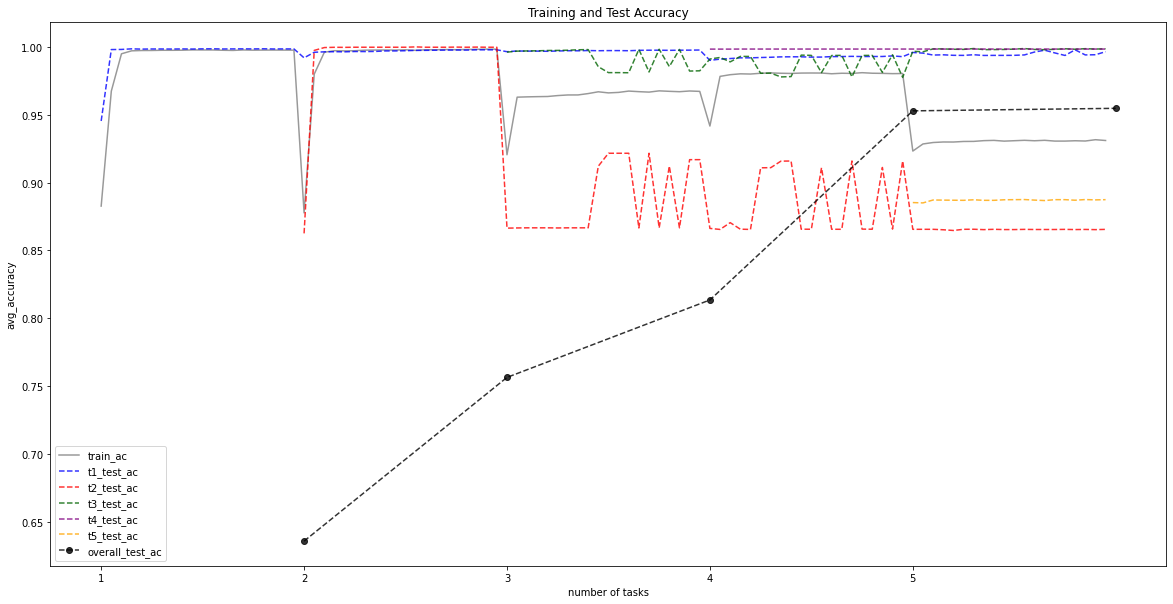

In [80]:
#Plot - use all data in test accuracy of each task
plt.figure(figsize=[20,10])
plt.plot(np.arange(0, int(5*num_epoch)), train_ac_list, color='grey', linestyle='-', label='train_ac', alpha=0.8)
plt.plot(np.arange(0, int(5*num_epoch)), t1_test_ac_list, color='blue', linestyle='--', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(int(1*num_epoch), int(5*num_epoch)), t2_test_ac_list, color='red', linestyle='--', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(int(2*num_epoch), int(5*num_epoch)), t3_test_ac_list, color='darkgreen', linestyle='--', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(int(3*num_epoch), int(5*num_epoch)), t4_test_ac_list, color='purple', linestyle='--', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(int(4*num_epoch), int(5*num_epoch)), t5_test_ac_list, color='orange', linestyle='--', label='t5_test_ac', alpha=0.8)
plt.plot([20, 40, 60, 80, 100], test_ac_list, color='black', marker='o', linestyle='--', label='overall_test_ac', alpha=0.8)
plt.legend()
plt.title("Training and Test Accuracy")
plt.xlabel("number of tasks")
plt.ylabel("avg_accuracy")
plt.xticks([0, 20, 40, 60, 80],[1, 2, 3, 4, 5])
plt.show()

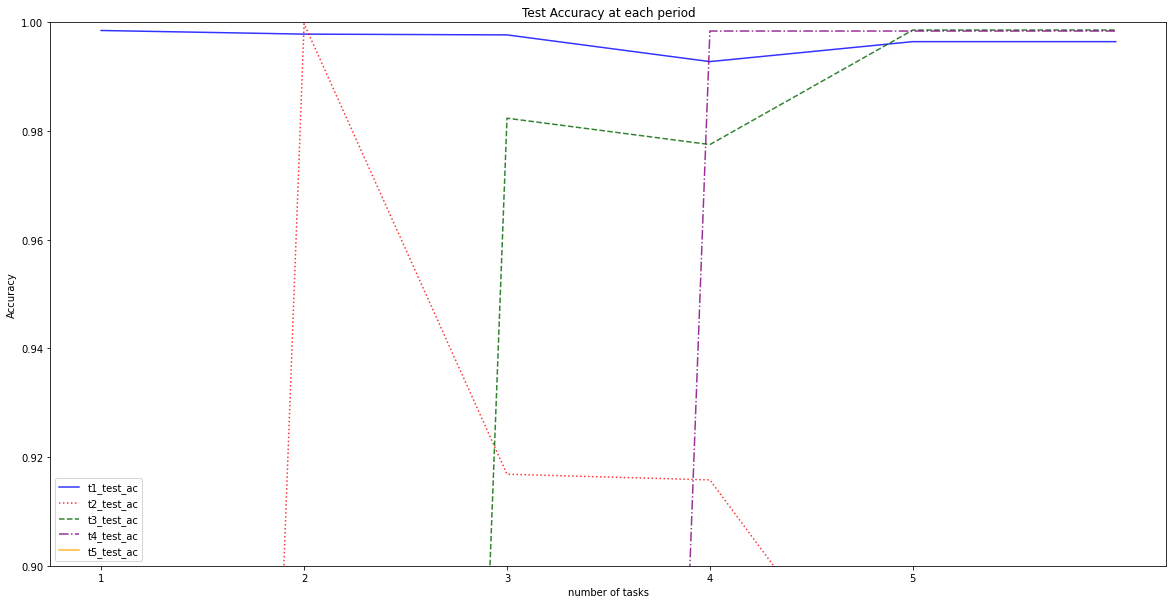

In [81]:
#Plot - average accuracy of each task
for i in range(5):
  task_ac_list[i][5] = task_ac_list[i][4]

plt.figure(figsize=[20,10])
plt.plot(np.arange(1, 7), task_ac_list[0], color='blue', linestyle='solid', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[1], color='red', linestyle='dotted', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[2], color='darkgreen', linestyle='dashed', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[3], color='purple', linestyle='dashdot', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[4], color='orange', linestyle='solid', label='t5_test_ac', alpha=0.8)
plt.legend()
plt.title("Test Accuracy at each period")
plt.xlabel("number of tasks")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([0.9, 1])
plt.show()


In [ ]:
"""
#Predict Sample 10 examples from MNIST
print("\nPredict \n")
idx = np.random.choice(10000, 10, True)

for i in idx:
    image = test_loader.dataset[i][0].reshape(1, 1, 28*28).float()
    output = model(image.to(device))
    y_pred = torch.argmax(output, dim=1)
    
    plt.figure(figsize=(1, 1))
    plt.imshow(test_loader.dataset[i][0].reshape(28,28), cmap=plt.cm.gray_r)
    plt.show()
    print("true_label: {}, y_pred: {}\n".format(test_loader.dataset[i][1], y_pred[0]))
"""